## Performance of the CPL
Author: Clara Hoffmann \
Measures the performance of the CPL on the precise validation set.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy as sp
from tqdm import tqdm
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from helpers import (Fy, find_closest_element,  compute_coverage, #predict_single_density,
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)
from density_predictor_class_val import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/B_zeta_val.npy')
beta = np.genfromtxt('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/beta.csv', delimiter = ',')

true_y = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/labels_val.npy')
true_z = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/tr_labels_val.npy')

B_zeta = B_zeta[np.abs(true_y) < 50,:] 
true_z = true_z[np.abs(true_y) < 50]
true_y = true_y[np.abs(true_y) < 50]

density_path = '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 500

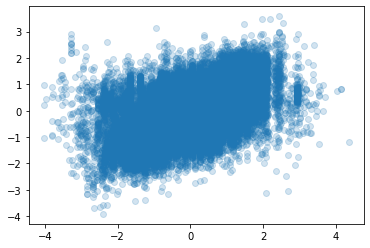

In [3]:
plt.scatter(true_z, B_zeta.dot(beta), alpha = 0.2)

(-20.0, 20.0)

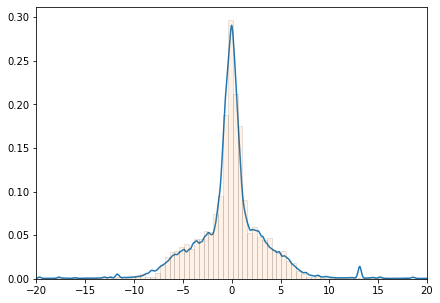

In [4]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.plot(density['axes'], density['pdf'])
ax.hist(true_y, bins=200, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.set_xlim(-20,20)

In [5]:
dens = density_predictor(B_zeta, true_y, density, no_points)

In [6]:
result_va_ridge = dens.get_density('va_ridge')
result_hmc_ridge = dens.get_density('hmc_ridge')

  0%|          | 55/94805 [00:00<02:53, 547.56it/s]

computing densities for each observation


  0%|          | 233/94805 [00:00<00:40, 2318.37it/s]

computing mean prediction for each observation


  1%|          | 638/94805 [00:00<00:14, 6377.22it/s]

computing variance prediction for each observation


100%|██████████| 94805/94805 [00:10<00:00, 9459.72it/s] 


In [7]:
result_va_horse = dens.get_density('va_horseshoe')
result_hmc_horse = dens.get_density('hmc_horseshoe')

100%|██████████| 94805/94805 [00:10<00:00, 8973.12it/s] 


In [8]:
z_pred = B_zeta.dot(beta) 
y_pred = np.array([density.loc[find_closest_element(norm.cdf(i), density['cdf']), 'axes'] for i in tqdm(z_pred)])

100%|██████████| 94805/94805 [00:59<00:00, 1590.19it/s]


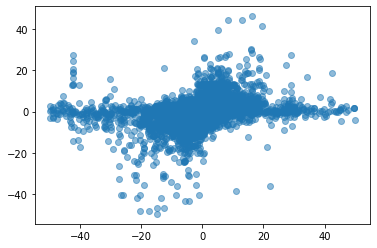

In [9]:
plt.scatter(true_y, y_pred , alpha = 0.5)

In [10]:
print('Validation Performance: ' +
      '\nMSE:' +
     '\n CIL VA/Ridge: ' + str(np.mean((true_y - np.array(result_va_ridge['mean predictions']))**2)) +
     '\n CIL HMC/Ridge: ' + str(np.mean((true_y - np.array(result_hmc_ridge['mean prediction']))**2)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean((true_y - np.array(result_va_horse['mean prediction']))**2)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean((true_y - np.array(result_hmc_horse['mean prediction']))**2)) +
     '\n CIL No Bayes: ' + str(np.mean((true_y - y_pred)**2)) +
     '\n CIL Benchmark: ' + str(np.mean((true_y - 0)**2)) +
      
    '\nMAE:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])))) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])))) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])))) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])))) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred))) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0))) +
      
      '\nAccuracy:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])) < 6)) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])) < 6)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])) < 6)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])) < 6)) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred) < 6)) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0) < 6))
     )

Validation Performance: 
MSE:
 CIL VA/Ridge: 14.197569231699886
 CIL HMC/Ridge: 14.193295509434003
 CIL VA/Horseshoe: 14.245350759220743
 CIL HMC/Horseshoe: 14.179446065373147
 CIL No Bayes: 13.050320078795423
 CIL Benchmark: 16.62251706133643
MAE:
 CIL VA/Ridge: 2.3254266751964177
 CIL HMC/Ridge: 2.3248970764435963
 CIL VA/Horseshoe: 2.3332556180030495
 CIL HMC/Horseshoe: 2.324484629114582
 CIL No Bayes: 1.9274159357560738
 CIL Benchmark: 2.3982901745688525
Accuracy:
 CIL VA/Ridge: 0.9459733136437951
 CIL HMC/Ridge: 0.9460155055113127
 CIL VA/Horseshoe: 0.9469753704973366
 CIL HMC/Horseshoe: 0.9473867412056326
 CIL No Bayes: 0.9530720953536206
 CIL Benchmark: 0.9155740730974105


In [ ]:
df = pd.DataFrame({'va_ridge' : result_va_ridge['densities'],
                 'hmc_ridge' : result_hmc_ridge['densities'],
                 'va_horse' : result_va_horse['densities'],
                 'hmc_horse' : result_hmc_horse['densities']})

In [ ]:
df.to_csv('../../../../data/commaai/predictions/cil/densities.csv')